DIEBOLD-LI 2006, "Forecasting the Term Structure of Government Bond Yields", i.e. the Yield Curve

Author: [@sparshsah](https://github.com/sparshsah)

In [270]:
from typing import Final, Sequence
import warnings

import pandas as pd
import statsmodels.regression.linear_model as sm_lm
import statsmodels.tsa.ar_model as sm_ar
import statsmodels.tsa.vector_ar.var_model as sm_var

# https://github.com/sparshsah/foggy-statslib/blob/main/foggy_statslib/core.py
import foggy_statslib.core as fsc

# DATA

In [232]:
YCS: Final[pd.DataFrame] = (
    pd.read_csv(
        "data/treasury-gov_daily-treasury-par-yield-curve-rates.csv",
        index_col="Date",
        parse_dates=True,
    )
    .sort_index()
    .rename_axis(index="date", columns="tau")
    .rename(
        columns=lambda n_mo: (
            int(n_mo.split()[0]) if n_mo.split()[1] == "Mo"
            else (
                int(n_mo.split()[0])*12 if n_mo.split()[1] == "Yr"
                else int("ERR")
            )            
        )
    )
    / 100
)
YCS.loc[:, 0] = 0
YCS = YCS.sort_index(axis="columns")

YCS.describe()

tau,0,1,2,3,4,6,12,24,36,60,84,120,240,360
count,8008.0,5108.000000,803.000000,8004.000000,0.0,8007.000000,8007.000000,8007.000000,8007.000000,8007.000000,8007.000000,8007.000000,7068.000000,7013.000000
mean,0.0,0.011893,0.009332,0.026178,NaN,0.027428,0.028642,0.031560,0.033691,0.037591,0.040643,0.043008,0.043998,0.048258
std,0.0,0.014544,0.010175,0.023005,NaN,0.023387,0.023428,0.023723,0.023281,0.022239,0.021388,0.020370,0.017212,0.019750
min,0.0,0.000000,0.000000,0.000000,NaN,0.000200,0.000400,0.000900,0.001000,0.001900,0.003600,0.005200,0.008700,0.009900
25%,0.0,0.000600,0.000600,0.001600,NaN,0.002600,0.004300,0.008100,0.011500,0.017100,0.021400,0.024950,0.027900,0.030400
50%,0.0,0.005100,0.001200,0.021000,NaN,0.021800,0.023900,0.027400,0.029700,0.035100,0.038900,0.042200,0.045700,0.046600
75%,0.0,0.018000,0.020700,0.049300,NaN,0.050700,0.050500,0.052400,0.054200,0.056500,0.058500,0.059000,0.057600,0.063900
max,0.0,0.052700,0.024800,0.082600,NaN,0.084900,0.086400,0.090500,0.091100,0.091000,0.091200,0.090900,0.083000,0.091800


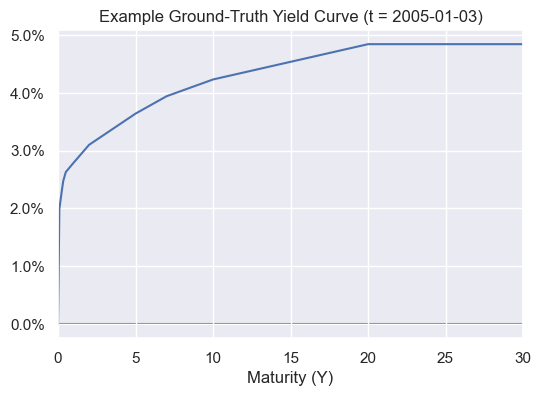

<Axes: title={'center': 'Example Ground-Truth Yield Curve (t = 2005-01-03)'}, xlabel='Maturity (Y)'>

In [326]:
t = "2005-01-03"
fsc.plot(
    YCS.loc[t, :].interpolate().rename(index=lambda months: months/12).rename_axis(index="Maturity (Y)"),
    ypct=True,
    title=f"Example Ground-Truth Yield Curve (t = {t})",
    figsize=(6,4),
)

# MODEL

Modified Nelson-Siegel:

$$ y^\tau_t := \beta^1_t + \beta^2_t\left(\frac{1 - e^{-\lambda\tau}}{\lambda\tau}\right) + \beta^3_t\left(\frac{1 - e^{-\lambda\tau}}{\lambda\tau} - e^{-\lambda\tau}\right) ,$$

with $\lambda := 0.0609$ set somewhat arbitrarily so that $1.793/\lambda := 30,$ where $1.793$ is some "point of maximum loading on the curvature factor", otherwise known as the "medium-term factor", and $30$ months is apparently what people consider a medium-term Treasury Note. No idea what's going on here, and the authors give no further explanation or evidence for this.

Therefore, we can simplify this to
$$ y^\tau_t := \beta^1_t + \beta^2_t\left(\frac{1 - e^{-0.0609\tau}}{0.0609\tau}\right) + \beta^3_t\left(\frac{1 - e^{-0.0609\tau}}{0.0609\tau} - e^{-0.0609\tau}\right) $$
$$ = \beta^1_t + \beta^2_t\left(\frac{1 - 0.9409^\tau}{0.0609\tau}\right) + \beta^3_t\left(\frac{1 - 0.9409^\tau}{0.0609\tau} - 0.9409^\tau\right) .$$

Let us define $x^{2,\tau}_t$ to be the factor on $\beta^2_t$ and $x^{3,\tau}_t$ similarly for $\beta^3_t$.

I am going to tweak this a bit by actually redefining $x2 := -x2$ and $x3 := -x3$. This makes the $\beta$'s signs more intuitive, as it will on average have positive loading on the level and slope (representing a climb over maturities) and negative on the curvature (representing a flattening out over maturities).

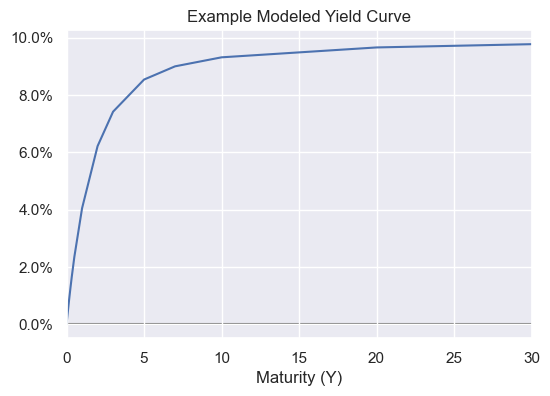

<Axes: title={'center': 'Example Modeled Yield Curve'}, xlabel='Maturity (Y)'>

In [324]:
L: Final[float] = 0.0609
TAUS: Final[Sequence[int]] = YCS.columns


def _get_x1(
    tau: int = 0,
    l: float = L,
) -> float:
    _ = tau, l
    return 1

def _get_x2(
    tau: int = 0,
    l: float = L,
) -> float:
    """Get the loading on slope coefficient at this maturity."""
    wtf = math.exp(- l*tau)
    numerator =  1 - wtf
    denominator = l * tau
    x2 = numerator / denominator
    return -x2

def _get_x3(
    tau: int = 0,
    l: float = L,
) -> float:
    """Get the loading on curvature coefficient at this maturity."""
    wtf = math.exp(- l*tau)
    numerator =  1 - wtf
    denominator = l * tau
    x2 = numerator / denominator
    x3 = x2 - wtf
    return -x3


def _get_y(
    tau: int = 0,
    beta: pd.Series = pd.Series({"beta1": 0.10, "beta2": 0.10, "beta3": -0.05}, name="betas"),
) -> float:
    """Get modeled yield at this maturity, given level, slope, and curvature coefficients."""
    return 0 if tau == 0 else (
        beta["beta1"]*_get_x1(tau=tau)
        + beta["beta2"]*_get_x2(tau=tau)
        + beta["beta3"]*_get_x3(tau=tau)
    )

def get_y(
    beta: pd.Series = pd.Series({"beta1": 0.10, "beta2": 0.10, "beta3": -0.05}, name="betas"),
) -> pd.Series:
    return pd.Series(
        {
            tau: _get_y(
                tau=tau,
                beta=beta,
            )
            for tau in TAUS
        }
    ).rename(index=lambda months: months/12).rename_axis(index="Maturity (Y)")


fsc.plot(
    get_y(),
    ypct=True,
    title="Example Modeled Yield Curve",
    figsize=(6,4)
)

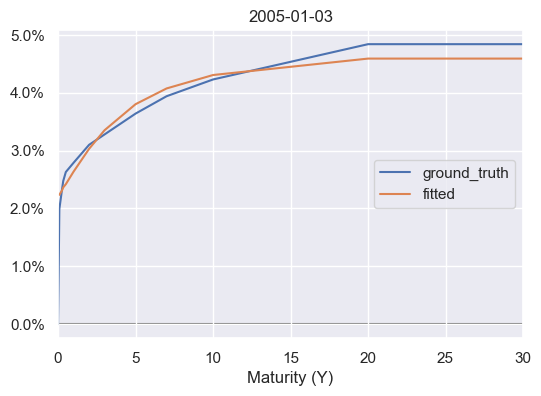

<Axes: title={'center': '2005-01-03'}, xlabel='Maturity (Y)'>

In [325]:
def get_dta(
    t: pd.Timestamp | str = t,
) -> pd.DataFrame:
    """Construct y, X for a given date, ready for regression."""
    y = YCS.loc[t, 1:]
    X = pd.DataFrame(
        {
            tau: pd.Series(
                {
                    "x1": _get_x1(tau=tau),
                    "x2": _get_x2(tau=tau),
                    "x3": _get_x3(tau=tau),
                },
                name=tau
            )
            for tau in TAUS[1:]
        }
    ).rename_axis(index="tau").T
    y = y.dropna()
    X = X.reindex(index=y.index)
    return y, X


def _get_f(
    t: pd.Timestamp | str = t,
) -> pd.Series | None:
    """Get fitted model estimated off yield curve for a given date."""
    y, X = get_dta(t=t)
    if len(y):
        m = sm_lm.OLS(y, X, missing="drop")
        f = m.fit()
        return f
    else:
        return None

def get_beta(
    t: pd.Timestamp | str = t,
) -> pd.Series | None:
    """Get betas estimated off yield curve for a given date."""
    f = _get_f(t=t)
    if f is not None:
        beta = (
            f.params
            .rename(index=lambda xn: xn.replace("x", "beta"))
            .rename_axis(index="beta")
            .rename(t)
        )
        return beta
    else:
        return None

def get_betas() -> pd.DataFrame:
    """Get a timeseries of beta's, estimated off each date in YCS."""
    betas = {
        t: get_beta(t=t)
        for t in YCS.index
    }
    return pd.DataFrame(
        {
            t: beta for (t, beta) in betas.items()
            if beta is not None
        }
    ).T

def est(
    t: pd.Timestamp | str = t,
) -> pd.DataFrame:
    """Fit (in-sample) the yield curve for a given date."""
    ground_truth = YCS.loc[t, :].interpolate()
    f = _get_f(t=t)
    fitted = f.fittedvalues.reindex(index=ground_truth.index).interpolate()
    return pd.DataFrame(
        {
            "ground_truth": ground_truth,
            "fitted": fitted,
        }
    ).rename(index=lambda months: months/12).rename_axis(index="Maturity (Y)")


fsc.plot(
    est(),
    ypct=True,
    figsize=(6,4),
    title=t,
)

In [300]:
def _get_f_beta(
    betas: pd.DataFrame,
    t: pd.Timestamp | str = t,
) -> sm_var.VARResults:
    """Get fitted VAR coefficients for the beta's, based on data seen so far."""
    observed_betas = betas.loc[:t, :]
    with warnings.catch_warnings():
        # betas has DatetimeIndex, but freq=None
        warnings.simplefilter("ignore")
        m = sm_var.VAR(
            observed_betas,
        )
    f = m.fit()
    return f

def _get_coef_beta(
    betas: pd.DataFrame,
    t: pd.Timestamp | str = t,
) -> pd.DataFrame:
    """Get fitted VAR coefficients for the beta's, based on data seen so far."""
    f = _get_f_beta(betas=betas, t=t)
    assert set(f.params.index) == {"const", "L1.beta1", "L1.beta2", "L1.beta3"}, f.params
    return f.params

def get_coefs_betas(
    betas: pd.DataFrame,
) -> pd.Series:
    """Get timeseries of backtest VAR coefficients for the beta's, based on data seen so far."""
    coefs = {
        t: _get_coef(
            betas=betas,
            t=t,
        )
        for t in beta.index
    }
    return pd.DataFrame(coefs).rename_axis(index="date").T

def get_betas_forecasted(
    betas: pd.DataFrame,
) -> pd.Series:
    fs = {
        t: _get_f_beta(
            betas=betas,
            t=t,
        )
        # skip first few dates (not enough data to estimate loading on lags)
        for t in betas.index[12:]
    }
    betas_forecasted = pd.DataFrame(
        {
            t: f.fittedvalues.loc[t, :]
            for (t, f) in fs.items()
        }
    ).rename_axis(columns="date").T
    return betas_forecasted

In [296]:
betas

beta,beta1,beta2,beta3
1990-01-02,0.080140,0.001589,0.002390
1990-01-03,0.080556,0.001538,0.001880
1990-01-04,0.080525,0.001999,0.001854
1990-01-05,0.080722,0.002855,0.001379
1990-01-08,0.081061,0.002971,0.002099
...,...,...,...
2021-12-27,0.020014,0.020193,0.008263
2021-12-28,0.020147,0.020363,0.008136
2021-12-29,0.020899,0.021283,0.008960
2021-12-30,0.020621,0.020663,0.009624


In [302]:
betas_forecasted = get_betas_forecasted(betas=betas)    
betas_forecasted

,beta1,beta2,beta3
date,,,
1990-01-19,0.083079,0.003379,-0.001092
1990-01-22,0.082683,0.003466,-0.000158
1990-01-23,0.083226,0.004019,-0.001319
1990-01-24,0.083246,0.004570,-0.000571
1990-01-25,0.084704,0.005787,-0.002176
...,...,...,...
2021-12-27,0.020452,0.020471,0.010169
2021-12-28,0.020017,0.020093,0.008355
2021-12-29,0.020150,0.020263,0.008229


In [322]:
ys = pd.DataFrame(
    {
        "ground_truth": YCS.loc[t, :],
        "fitted": get_y(beta=betas.loc[t, :]),
        "forecasted": get_y(beta=betas_forecasted.loc[t, :]),
    },
).rename(index=lambda months: months/12).rename_axis("Maturity (Y)")

ys

,ground_truth,fitted,forecasted
Maturity (Y),,,
0.000000,0.0000,0.000000,0.000000
0.083333,0.0199,0.022363,0.021521
0.166667,NaN,0.022727,0.021932
0.250000,0.0232,0.023093,0.022342
0.333333,NaN,0.023460,0.022751
0.500000,0.0263,0.024196,0.023563
1.000000,0.0279,0.026367,0.025917
2.000000,0.0310,0.030305,0.030080
3.000000,0.0328,0.033528,0.033420


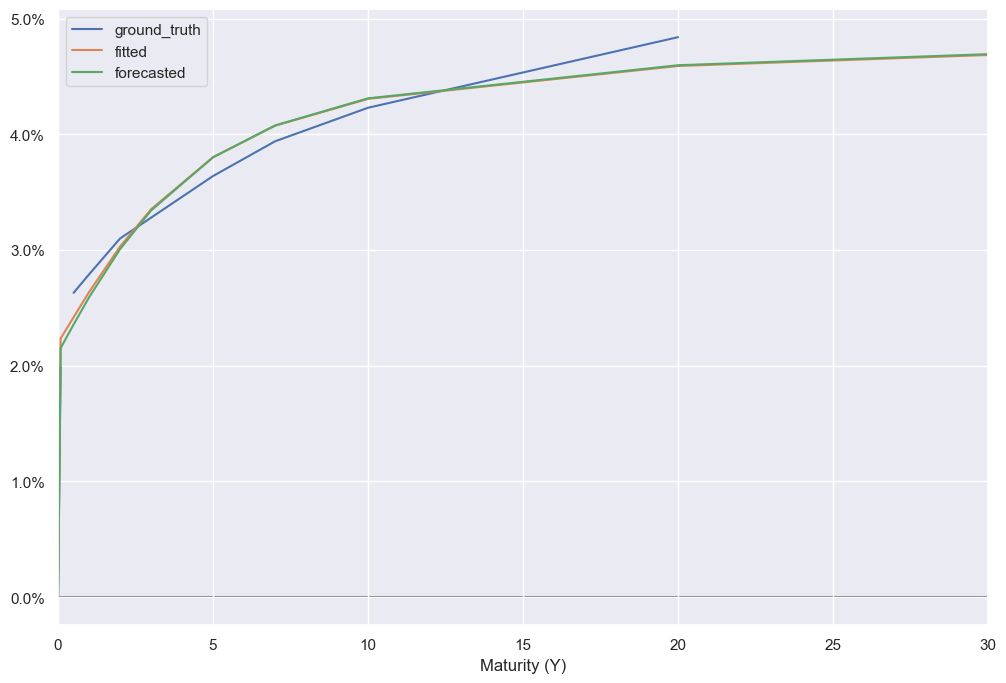

<Axes: xlabel='Maturity (Y)'>

In [327]:
fsc.plot(
    ys,
    ypct=True, 
)